## Looking at dataset

In [2]:
# Import dataset and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

# Load dataset
df = pd.read_csv('/Users/holly/Desktop/PUBH 2242/cleaned_asha_data.csv')

# Display first 5 rows of dataset
print(df.head())

# Display column names to identify the target column
print(df.columns)

# more data analysis on the postdescription column
print(df['PostDescription'].describe())


            Name                                          PostTitle  \
0          Brian                   How should we improve hospitals?   
1    hellomorgan  Can you get HSV-2 from someone who’s never had...   
2           sdiv        12 Years In - Sexually transmitted diseases   
3  mastergousau2  Is this fordyce spot or genital herpes or geni...   
4      khack2471  Hpv contagious even if dormant? - Sexually tra...   

                                     PostDescription             Date  \
0  Dear members,Many of us, including myself, hav...     Mar 13, 2019   
1  I had unprotected sex with a man last week and...  March 13, 2019    
2  I’m feeling...hopeless. I’ve had great strides...   June 29, 2019    
3  **Attached photo(uncircumcised flaccid penis(f...   June 28, 2019    
4  Since I have had hpv on numerous of occasions ...   June 19, 2019    

        Time  ReplyCount  
0   10:24 am         870  
1   10:24 am           3  
2    4:02 pm           1  
3    3:19 am           2  

### Trying to seperate the people who probably already have an STD/STI vs those who don't, so we can focus on those who are questioning

In [3]:
# Keywords for categorization
keywords = [
    'std', 'got diagnosed', 'my std', 'positive for', 
    'diagnosed with herpes', 'diagnosed with chlamydia', 
    'diagnosed with hpv', 'diagnosed with hsv1', 
    'diagnosed with hsv2', 'diagnosed with hsv', 
    'diagnosed with hiv', 'diagnosed with syphillis'
]

# Categorize posts
df['category'] = df['PostDescription'].apply(
    lambda x: 'Already has STD' if any(keyword in str(x).lower() for keyword in keywords) else 'Questioning'
)

# Count the number of posts in each category
category_counts = df['category'].value_counts()
print(category_counts)

category
Questioning        468
Already has STD    137
Name: count, dtype: int64


### Seperating low risk vs high risk using key words

In [4]:

# Define high-risk keywords for categorizing posts
high_risk_keywords = ['unprotected sex', 'multiple partners', 'exposure', 'symptoms', 'itching', 'burning', 'pain', 'discharge']

# Function to categorize risk based on keywords
def categorize_risk(post):
    post = str(post).lower()
    if any(keyword in post for keyword in high_risk_keywords):
        return 'High Risk'
    return 'Low Risk'

# Apply the function to create a 'risk_level' column
df['risk_level'] = df.apply(lambda row: 'Already has STD' if row['category'] == 'Already has STD' else categorize_risk(row['PostDescription']), axis=1)

# Check distribution of risk levels
print(df['risk_level'].value_counts())


risk_level
Low Risk           341
Already has STD    137
High Risk          127
Name: count, dtype: int64


### Text Vectorization and Data Preparation for Machine Learning


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter the dataset to include only posts labeled as "Questioning" and their risk levels
questioning_df = df[df['category'] == 'Questioning']

# Split data into features (X) and labels (y)
X = questioning_df['PostDescription']
y = questioning_df['risk_level']

# Train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting features for efficiency
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


### Train and Evaluate the Classifier

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the model
classifier = LogisticRegression()

# Train the model
classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7446808510638298
              precision    recall  f1-score   support

   High Risk       1.00      0.11      0.20        27
    Low Risk       0.74      1.00      0.85        67

    accuracy                           0.74        94
   macro avg       0.87      0.56      0.52        94
weighted avg       0.81      0.74      0.66        94



#### Logistic Regression Classifier: 74% accuracy rate

## Fine-tuning and Experimentation


### 1. Fine tuning with random forest:

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Using a different classifier for experimentation
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)
y_pred_rf = rf_classifier.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7659574468085106
              precision    recall  f1-score   support

   High Risk       1.00      0.19      0.31        27
    Low Risk       0.75      1.00      0.86        67

    accuracy                           0.77        94
   macro avg       0.88      0.59      0.59        94
weighted avg       0.82      0.77      0.70        94



#### Accuracy of 77%

### 2. Fine tuning with decison trees

In [8]:
# Initialize the model
dt_classifier = DecisionTreeClassifier(random_state=42)


# Train the model
dt_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test_tfidf)

# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))



Decision Tree Accuracy: 0.9361702127659575
              precision    recall  f1-score   support

   High Risk       0.86      0.93      0.89        27
    Low Risk       0.97      0.94      0.95        67

    accuracy                           0.94        94
   macro avg       0.92      0.93      0.92        94
weighted avg       0.94      0.94      0.94        94



#### Accuracy score of 94%!!

## Making the model can predict the risk level of a post (sample post is directly copied form a reddit post)


In [21]:
def predict_risk_level(post):
    post_tfidf = vectorizer.transform([post])
    prediction = classifier.predict(post_tfidf)
    return prediction[0]

# Test the function with a sample post
sample_post = '''I had sex with this guy a week ago, and my fufu was kinda itchy for a few days, but no smell, so I was like ok it's a lil + thrush +. still no smell but this morning my discharge was a very light white/green.
Google says green mean STI? The itching is slowly going away but this morning I was taken a back!
Booked in for doctors next week.'''

# Predict risk level and add a comment based on the prediction. If low risk, suggest doing a routine check up. If high risk, suggest seeking medical attention.
risk_prediction = predict_risk_level(sample_post)
print(predict_risk_level(sample_post))
if risk_prediction == 'Low Risk':
    comment = "It could be a simple infection, but it's always good to get it checked out. Consider discussing your sexual health with your primary physician and getting a routine check-up to be safe."
else:
    comment = "The symptoms you're experiencing could be indicative of an STI. It's important to get tested and seek medical advice as soon as possible."
print(comment)



Low Risk
It could be a simple infection, but it's always good to get it checked out. Consider discussing your sexual health with your primary physician and getting a routine check-up to be safe.


## Trying some analysis and visualization

In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/holly/Desktop/PUBH 2242/cleaned_asha_data.csv')

# Display the first few rows of the DataFrame
print(df.head())

            Name                                          PostTitle  \
0          Brian                   How should we improve hospitals?   
1    hellomorgan  Can you get HSV-2 from someone who’s never had...   
2           sdiv        12 Years In - Sexually transmitted diseases   
3  mastergousau2  Is this fordyce spot or genital herpes or geni...   
4      khack2471  Hpv contagious even if dormant? - Sexually tra...   

                                     PostDescription             Date  \
0  Dear members,Many of us, including myself, hav...     Mar 13, 2019   
1  I had unprotected sex with a man last week and...  March 13, 2019    
2  I’m feeling...hopeless. I’ve had great strides...   June 29, 2019    
3  **Attached photo(uncircumcised flaccid penis(f...   June 28, 2019    
4  Since I have had hpv on numerous of occasions ...   June 19, 2019    

        Time  ReplyCount  
0   10:24 am         870  
1   10:24 am           3  
2    4:02 pm           1  
3    3:19 am           2  

In [12]:
# Display basic information about the DataFrame
print(df.info())

# Display summary statistics of the DataFrame
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             605 non-null    object
 1   PostTitle        605 non-null    object
 2   PostDescription  605 non-null    object
 3   Date             605 non-null    object
 4   Time             605 non-null    object
 5   ReplyCount       605 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 28.5+ KB
None
        ReplyCount
count   605.000000
mean     21.166942
std     106.768628
min       0.000000
25%       1.000000
50%       2.000000
75%       5.000000
max    1510.000000
Name               0
PostTitle          0
PostDescription    0
Date               0
Time               0
ReplyCount         0
dtype: int64


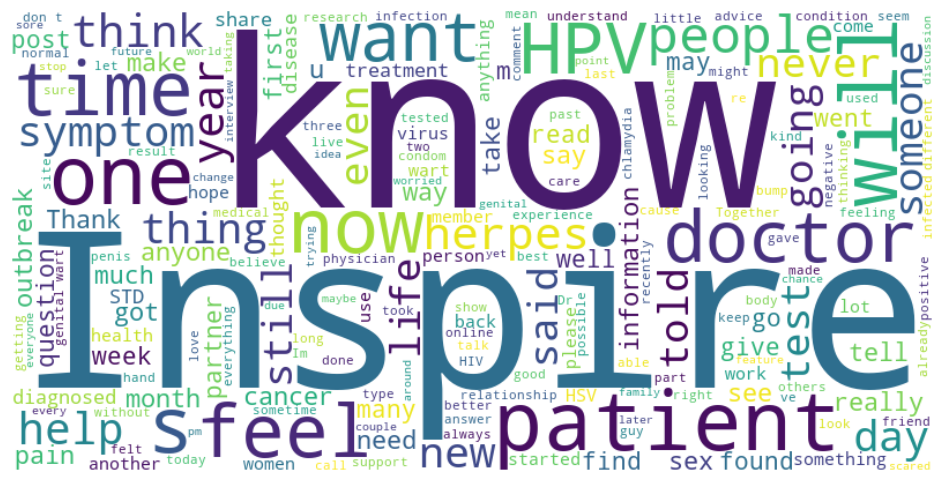

In [13]:
from wordcloud import WordCloud

# Combine all text data into a single string
text_data = ' '.join(df['PostDescription'].dropna().tolist())

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# what's the most common words in the postdescription column
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text data
count_data = count_vectorizer.fit_transform(df['PostDescription'].dropna())

# Get feature names
feature_names = count_vectorizer.get_feature_names_out()

# Create a DataFrame with the word counts
word_count_df = pd.DataFrame(count_data.toarray(), columns=feature_names)

# Display the top 10 most common words
print(word_count_df.sum().sort_values(ascending=False).head(25))


inspire     444
just        426
like        418
know        375
time        276
hpv         275
herpes      263
feel        257
don         254
sex         242
people      228
ve          228
years       223
patients    218
help        211
cancer      200
want        200
think       186
life        186
did         179
patient     176
test        174
said        166
new         166
going       166
dtype: int64


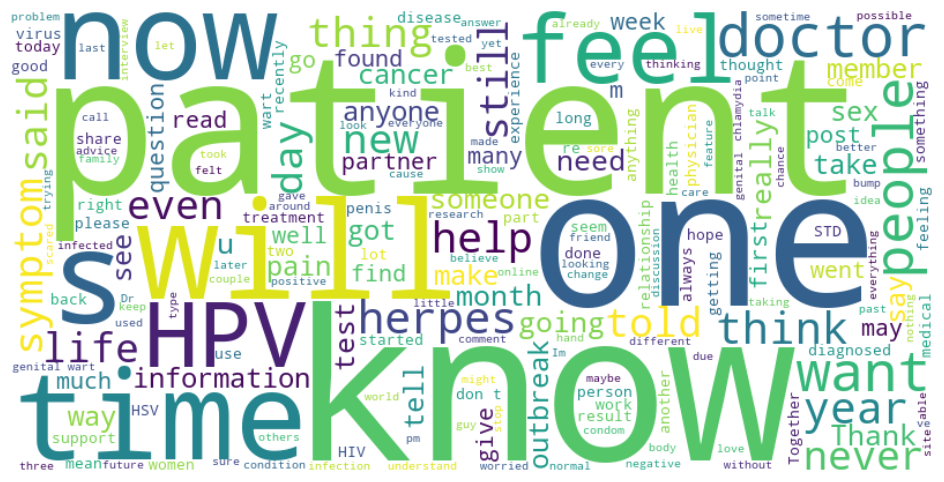

In [15]:
# do the word cloud again but remove stopwords and the word 'inspire'
from wordcloud import STOPWORDS

# Add 'inspire' to the list of stopwords
STOPWORDS.add('inspire')
STOPWORDS.add('community')

# Create a word cloud with the updated stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text_data)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
